In [25]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import torch
from tqdm import tqdm

from chipvi.utils.distributions import nb_cdf_r_p

warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")

DEVICE = torch.device("cuda:0")

In [2]:
BASE_DIR = Path("/lotterlab/users/abdul/repos/chipvi/runs/rp_info_loss")

# Plotting functions

In [36]:
pd.DataFrame([{"a": [1, 2, 3], "b": [4, 5, 6]}, {"a": [7, 8, 9], "b": [10, 11, 12]}])

,a,b
0,"[1, 2, 3]","[4, 5, 6]"
1,"[7, 8, 9]","[10, 11, 12]"


In [35]:
pd.DataFrame({1: {"a": [1, 2, 3], "b": [4, 5, 6]}, 2: {"a": [7, 8, 9], "b": [10, 11, 12]}})

,1,2
a,"[1, 2, 3]","[7, 8, 9]"
b,"[4, 5, 6]","[10, 11, 12]"


In [32]:
pd.DataFrame({"a": [1, 2, 3], "b": [4, 5, 6], "c": [7, 8, 9]}).melt()

,variable,value
0,a,1
1,a,2
2,a,3
3,b,4
4,b,5
5,b,6
6,c,7
7,c,8
8,c,9


In [39]:
def run_analysis(data_dir):
    def load_val_data(epoch):
        mu_1 = np.load(data_dir / f'val_mu_1_{epoch}.npy').squeeze()
        mu_2 = np.load(data_dir / f'val_mu_2_{epoch}.npy').squeeze()
        res_1 = np.load(data_dir / f'val_residual_1_{epoch}.npy').squeeze()
        res_2 = np.load(data_dir / f'val_residual_2_{epoch}.npy').squeeze()
        r_1 = np.load(data_dir / f'val_r_1_{epoch}.npy').squeeze()
        r_2 = np.load(data_dir / f'val_r_2_{epoch}.npy').squeeze()
        p_1 = np.load(data_dir / f'val_p_1_{epoch}.npy').squeeze()
        p_2 = np.load(data_dir / f'val_p_2_{epoch}.npy').squeeze()
        ll_1 = np.load(data_dir / f'val_ll_1_{epoch}.npy').squeeze()
        ll_2 = np.load(data_dir / f'val_ll_2_{epoch}.npy').squeeze()
        sd_ratio = np.load(data_dir / f'val_sd_ratio_r1_to_r2_{epoch}.npy').squeeze()
        x_1 = pd.DataFrame(
            np.load(data_dir / 'val_x_1.npy'),
            columns=["ctrl_reads_r1", "ctrl_mapq_r1", "ctrl_sd_r1", "exp_mapq_r1", "exp_sd_r1"]
            )
        x_2 = pd.DataFrame(
            np.load(data_dir / 'val_x_2.npy'),
            columns=["ctrl_reads_r2", "ctrl_mapq_r2", "ctrl_sd_r2", "exp_mapq_r2", "exp_sd_r2"]
            )
        y_1 = np.load(data_dir / 'val_y_1.npy').squeeze()
        y_2 = np.load(data_dir / 'val_y_2.npy').squeeze()
        

        df = pd.DataFrame({ 
            'mu_1': mu_1,
            'mu_2': mu_2,
            'res_1': res_1,
            'res_2': res_2,
            'r_1': r_1,
            'r_2': r_2,
            'p_1': p_1,
            'p_2': p_2,
            'll_1': ll_1,
            'll_2': ll_2,
            'y_1': y_1,
            'y_2': y_2,
            'sd_ratio': sd_ratio,
        })

        df = pd.concat([df, x_1, x_2], axis=1)

        return df

    epoch_dfs = []
    for i in tqdm(range(100)):
        try:
            epoch_dfs.append(load_val_data(i))
            # print(f"Loaded epoch {i}")
        except FileNotFoundError:
            break
    
    fig, axes = plt.subplots(5, 2, figsize=(20, 25))

    # biol_corrs = [np.corrcoef(df["res_1"], df["res_2"])[0][1] for df in epoch_dfs]
    # raw_corrs = [np.corrcoef(df["y_1"], df["y_2"])[0][1] for df in epoch_dfs]

    pearson_corrs = []
    spearman_corrs = [] 

    for epoch_idx, epoch_df in tqdm(enumerate(epoch_dfs)):
        for r1_sd, r1_sd_df in epoch_df.groupby("exp_sd_r1"):
            r1_sd_df["quantile_r1"] = nb_cdf_r_p(
                x=torch.tensor(r1_sd_df["y_1"].values).to(DEVICE),
                r=torch.tensor(r1_sd_df["r_1"].values).to(DEVICE),
                p=torch.tensor(r1_sd_df["p_1"].values).to(DEVICE),
                ).detach().cpu().numpy()
            r1_sd_df["quantile_r2"] = nb_cdf_r_p(
                x=torch.tensor(r1_sd_df["y_2"].values).to(DEVICE),
                r=torch.tensor(r1_sd_df["r_2"].values).to(DEVICE),
                p=torch.tensor(r1_sd_df["p_2"].values).to(DEVICE),
                ).detach().cpu().numpy()

            r2_sds = r1_sd_df["exp_sd_r2"].unique()
            if len(r2_sds) > 1:
                raise ValueError
            pearson_corrs.append({
                "(raw1, raw2)": np.corrcoef(r1_sd_df["y_1"], r1_sd_df["y_2"])[0][1],
                "(res1, res2)": np.corrcoef(r1_sd_df["res_1"], r1_sd_df["res_2"])[0][1],
                "(quant1, quant2)": np.corrcoef(r1_sd_df["quantile_r1"], r1_sd_df["quantile_r2"])[0][1],
                "(quant1, raw1)": np.corrcoef(r1_sd_df["quantile_r1"], r1_sd_df["y_1"])[0][1],
                "(quant2, raw2)": np.corrcoef(r1_sd_df["quantile_r2"], r1_sd_df["y_2"])[0][1],
                "epoch": epoch_idx,
            })

            spearman_corrs.append({
                "(raw1, raw2)": stats.spearmanr(r1_sd_df["y_1"], r1_sd_df["y_2"])[0],
                "(res1, res2)": stats.spearmanr(r1_sd_df["res_1"], r1_sd_df["res_2"])[0],
                "(quant1, quant2)": stats.spearmanr(r1_sd_df["quantile_r1"], r1_sd_df["quantile_r2"])[0],
                "(quant1, raw1)": stats.spearmanr(r1_sd_df["quantile_r1"], r1_sd_df["y_1"])[0],
                "(quant2, raw2)": stats.spearmanr(r1_sd_df["quantile_r2"], r1_sd_df["y_2"])[0],
                "epoch": epoch_idx,
            })

    epoch_pearson_corrs = pd.DataFrame(pearson_corrs)
    epoch_spearman_corrs = pd.DataFrame(spearman_corrs)
    for col_ix, col in enumerate(["(raw1, raw2)", "(res1, res2)", "(quant1, quant2)", "(quant1, raw1)", "(quant2, raw2)"]):
        sns.boxplot(
            data=epoch_pearson_corrs,
            x="epoch",
            y=col,
            ax=axes[col_ix, 0],
        )
        axes[col_ix, 0].set_title(f"Pearson {col}")
        sns.boxplot(
            data=epoch_spearman_corrs,
            x="epoch",
            y=col,
            ax=axes[col_ix, 1],
        )
        axes[col_ix, 1].set_title(f"Spearman {col}")

    return epoch_dfs

# Visualize

In [43]:
h_dfs[-10].iloc[0]

mu_1              4.546215
mu_2              2.624650
res_1            -3.546215
res_2            -4.882433
r_1              19.694380
r_2              12.475991
p_1               0.187546
p_2               0.173810
ll_1             -2.783834
ll_2             -2.382055
y_1               1.000000
y_2               0.000000
sd_ratio          1.860223
ctrl_reads_r1     0.000000
ctrl_mapq_r1      1.000000
ctrl_sd_r1        2.975306
exp_mapq_r1       0.999000
exp_sd_r1         2.710890
ctrl_reads_r2     0.000000
ctrl_mapq_r2      1.000000
ctrl_sd_r2        2.975306
exp_mapq_r2       1.000000
exp_sd_r2         1.860223
Name: 0, dtype: float32

 19%|█▉        | 19/100 [00:12<00:54,  1.49it/s]
1it [00:06,  6.86s/it]/lotterlab/users/abdul/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/lotterlab/users/abdul/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/lotterlab/users/abdul/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/lotterlab/users/abdul/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/lotterlab/users/abdul/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/lotterlab/users/abdul/miniconda3/lib/python3.12/site-packages/numpy/lib/functi

,mu_1,mu_2,res_1,res_2,r_1,r_2,p_1,p_2,ll_1,ll_2,...,ctrl_reads_r1,ctrl_mapq_r1,ctrl_sd_r1,exp_mapq_r1,exp_sd_r1,ctrl_reads_r2,ctrl_mapq_r2,ctrl_sd_r2,exp_mapq_r2,exp_sd_r2
0,4.006581,2.325644,-3.006581,-4.326216,17.937809,11.358509,0.182579,0.169952,-2.429941,-2.115764,...,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223
1,4.006581,2.325644,-2.006581,-4.326216,17.937809,11.358509,0.182579,0.169952,-1.882498,-2.115764,...,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223
2,4.006581,2.325644,-2.006581,-4.326216,17.937809,11.358509,0.182579,0.169952,-1.882498,-2.115764,...,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223
3,4.006581,2.325644,-2.006581,-4.326216,17.937809,11.358509,0.182579,0.169952,-1.882498,-2.115764,...,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223
4,4.006581,2.325644,-3.006581,-4.326216,17.937809,11.358509,0.182579,0.169952,-2.429941,-2.115764,...,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364027,2.392028,1.620619,-1.392028,-1.999520,10.574929,7.625123,0.184471,0.175283,-1.488197,-1.469473,...,0.0,1.000000,2.591536,0.999000,1.842645,0.0,1.000000,2.591536,1.000000,1.233800
8364028,2.420080,1.639356,-1.420080,-2.022638,13.878519,10.004599,0.148484,0.140790,-1.507725,-1.518121,...,2.0,0.999937,2.591536,0.999937,1.842645,2.0,0.999937,2.591536,1.000000,1.233800
8364029,2.448066,1.658309,-1.448066,-0.812222,18.209570,13.126611,0.118507,0.112162,-1.527758,-1.174790,...,4.0,0.999937,2.591536,0.999937,1.842645,4.0,0.999937,2.591536,0.999937,1.233800
8364030,2.448066,1.658309,-1.448066,1.655378,18.209570,13.126611,0.118507,0.112162,-1.527758,-1.977657,...,4.0,0.999937,2.591536,0.999937,1.842645,4.0,0.999937,2.591536,0.999937,1.233800


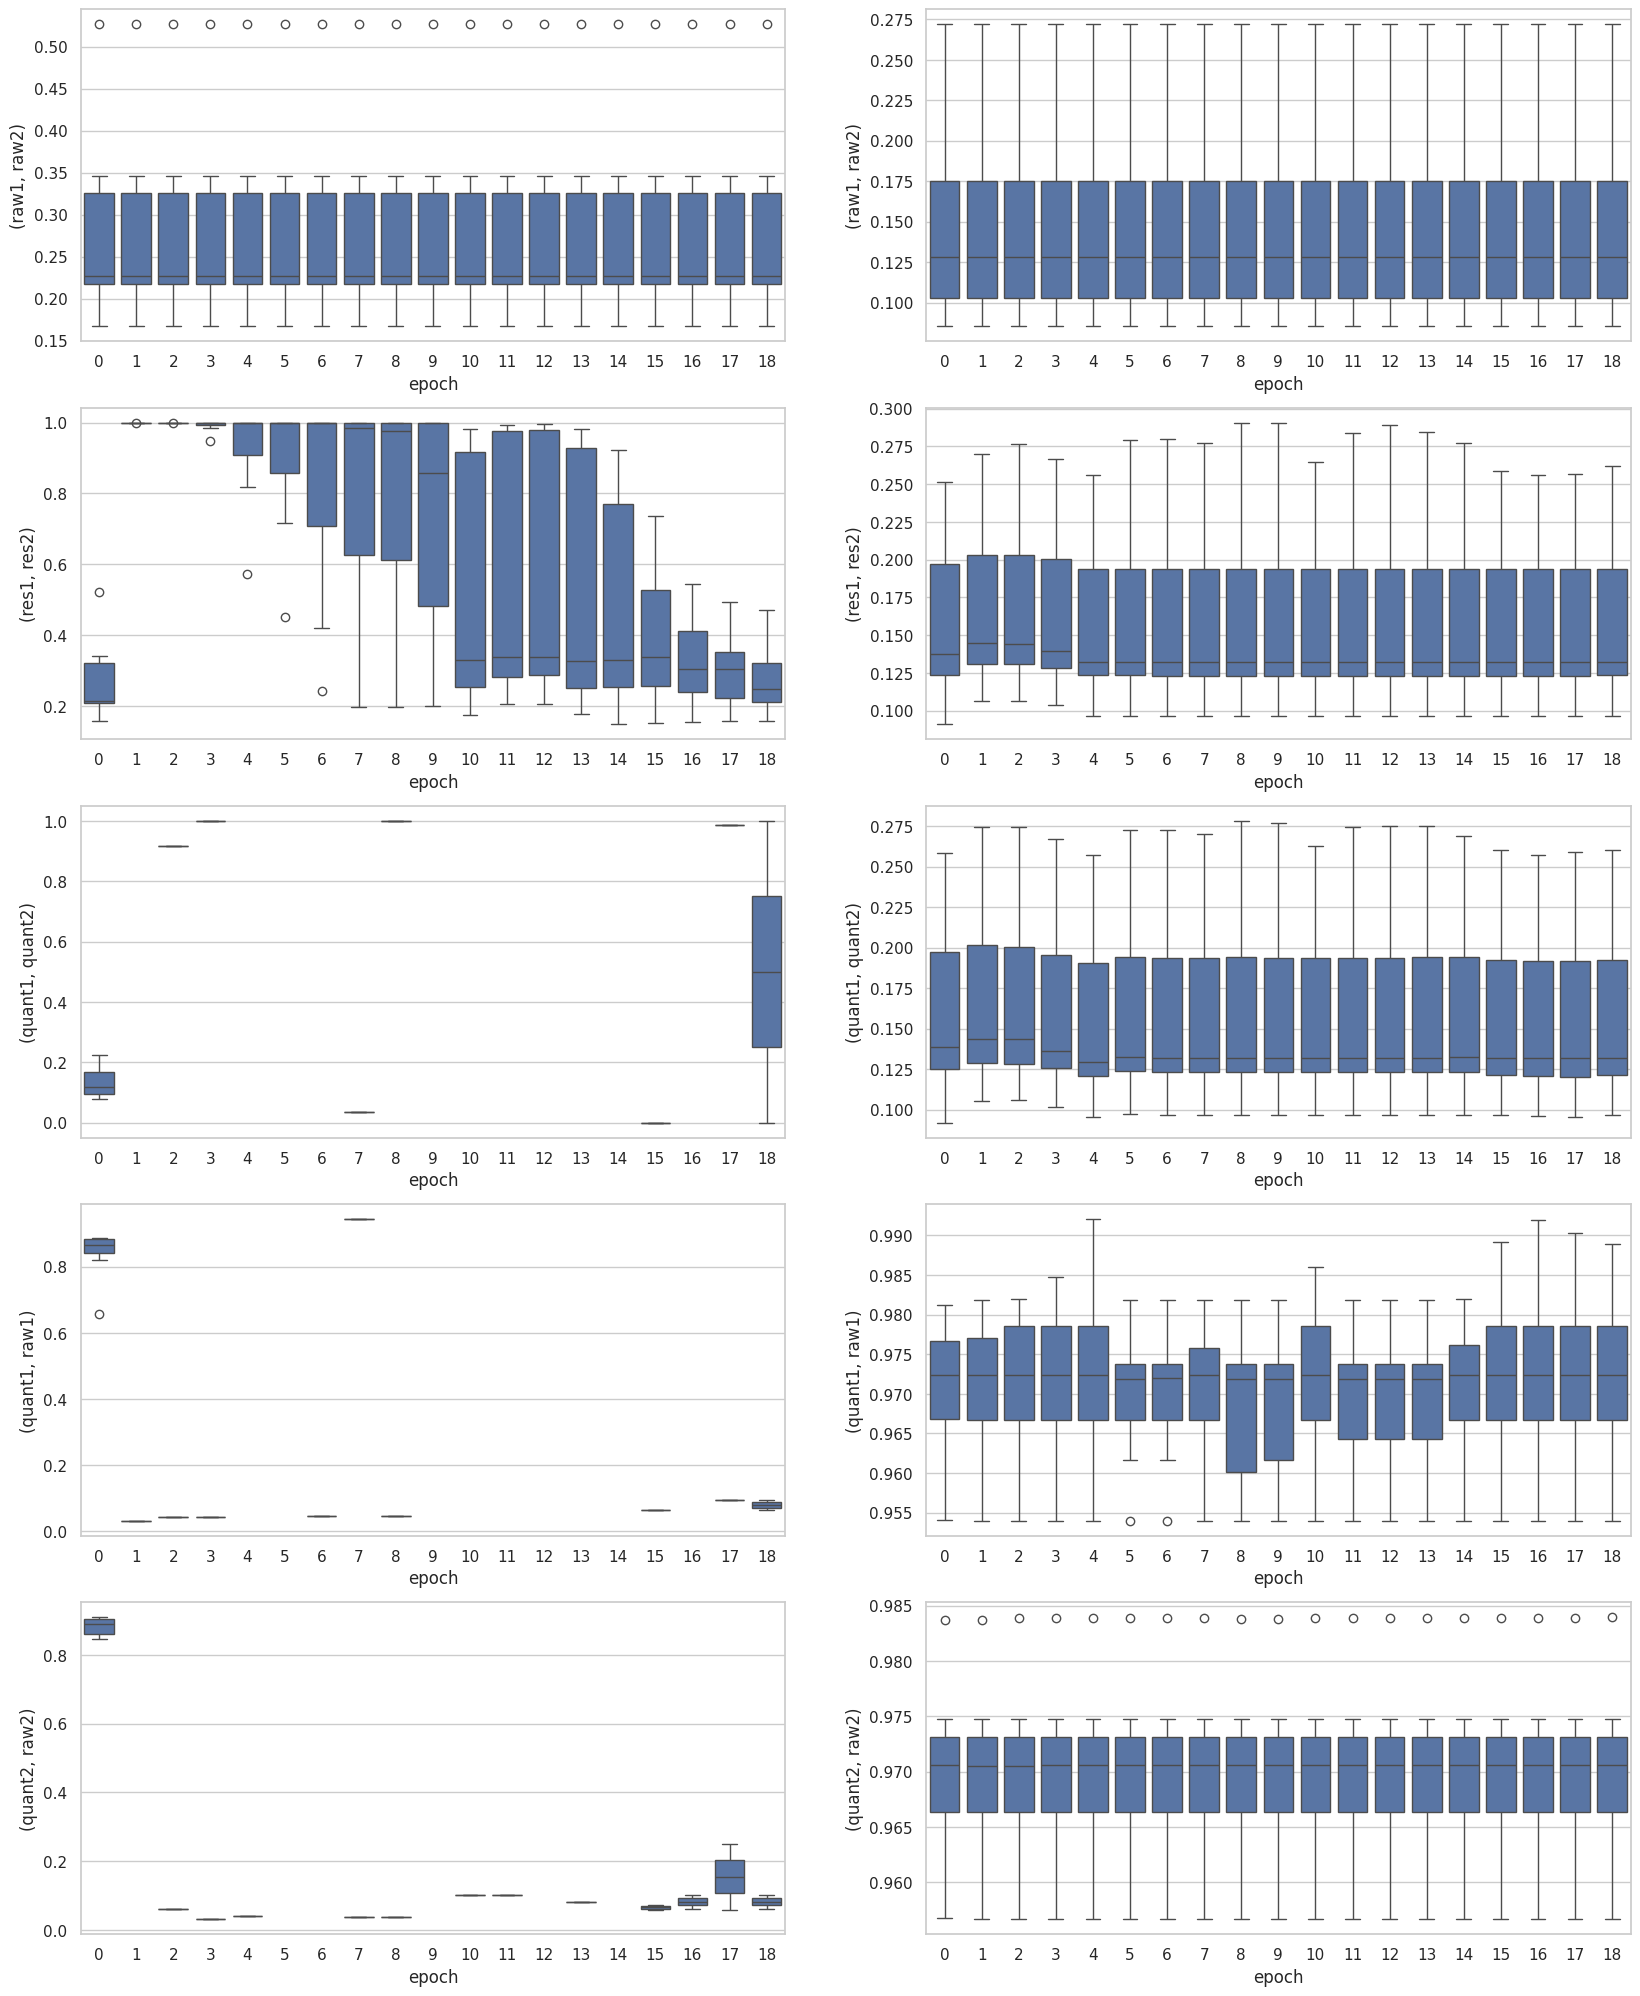

In [40]:
h_dfs = run_analysis(BASE_DIR / "h3k27me3" / "run_h3k27me3")
h_dfs[-1]

 16%|█▌        | 16/100 [00:11<01:00,  1.40it/s]
16it [02:00,  7.50s/it]


,mu_1,mu_2,res_1,res_2,r_1,r_2,p_1,p_2,ll_1,ll_2,...,ctrl_reads_r1,ctrl_mapq_r1,ctrl_sd_r1,exp_mapq_r1,exp_sd_r1,ctrl_reads_r2,ctrl_mapq_r2,ctrl_sd_r2,exp_mapq_r2,exp_sd_r2
0,2.441401,2.680864,-0.441401,-6.583412,1.849182,2.123464,0.569014,0.558010,-1.715491,-1.733742,...,1.0,0.999000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705
1,2.441401,2.680864,-0.441401,-6.583412,1.849182,2.123464,0.569014,0.558010,-1.715491,-1.733742,...,1.0,0.999000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705
2,2.439353,2.680864,-0.439353,-6.583412,1.861683,2.123464,0.567155,0.558010,-1.713429,-1.733742,...,0.0,1.000000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705
3,2.439353,2.680864,-0.439353,-6.583412,1.861683,2.123464,0.567155,0.558010,-1.713429,-1.733742,...,0.0,1.000000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705
4,2.441401,2.680864,-1.441401,-6.583412,1.849182,2.123464,0.569014,0.558010,-1.505525,-1.733742,...,1.0,0.999000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8773627,2.620446,2.348235,-0.620446,-2.418701,2.022590,1.922206,0.564382,0.549881,-1.707453,-1.478968,...,0.0,1.000000,2.758586,0.999937,2.629396,3.0,0.999926,2.591536,0.999937,1.793976
8773628,2.622519,2.346388,0.377481,-2.415387,2.008949,1.935263,0.566239,0.548010,-1.988243,-1.478002,...,1.0,0.999937,2.758586,0.999937,2.629396,2.0,0.999923,2.591536,0.999937,1.793976
8773629,2.622519,2.348228,1.377481,-4.212664,2.008949,1.922203,0.566239,0.549881,-2.332050,-1.534385,...,1.0,0.999937,2.758586,0.999937,2.629396,3.0,0.999921,2.591536,1.000000,1.793976
8773630,2.624584,2.346380,0.375416,-4.209349,1.995396,1.935259,0.568094,0.548010,-1.990332,-1.536779,...,2.0,0.999937,2.758586,0.999937,2.629396,2.0,0.999921,2.591536,1.000000,1.793976


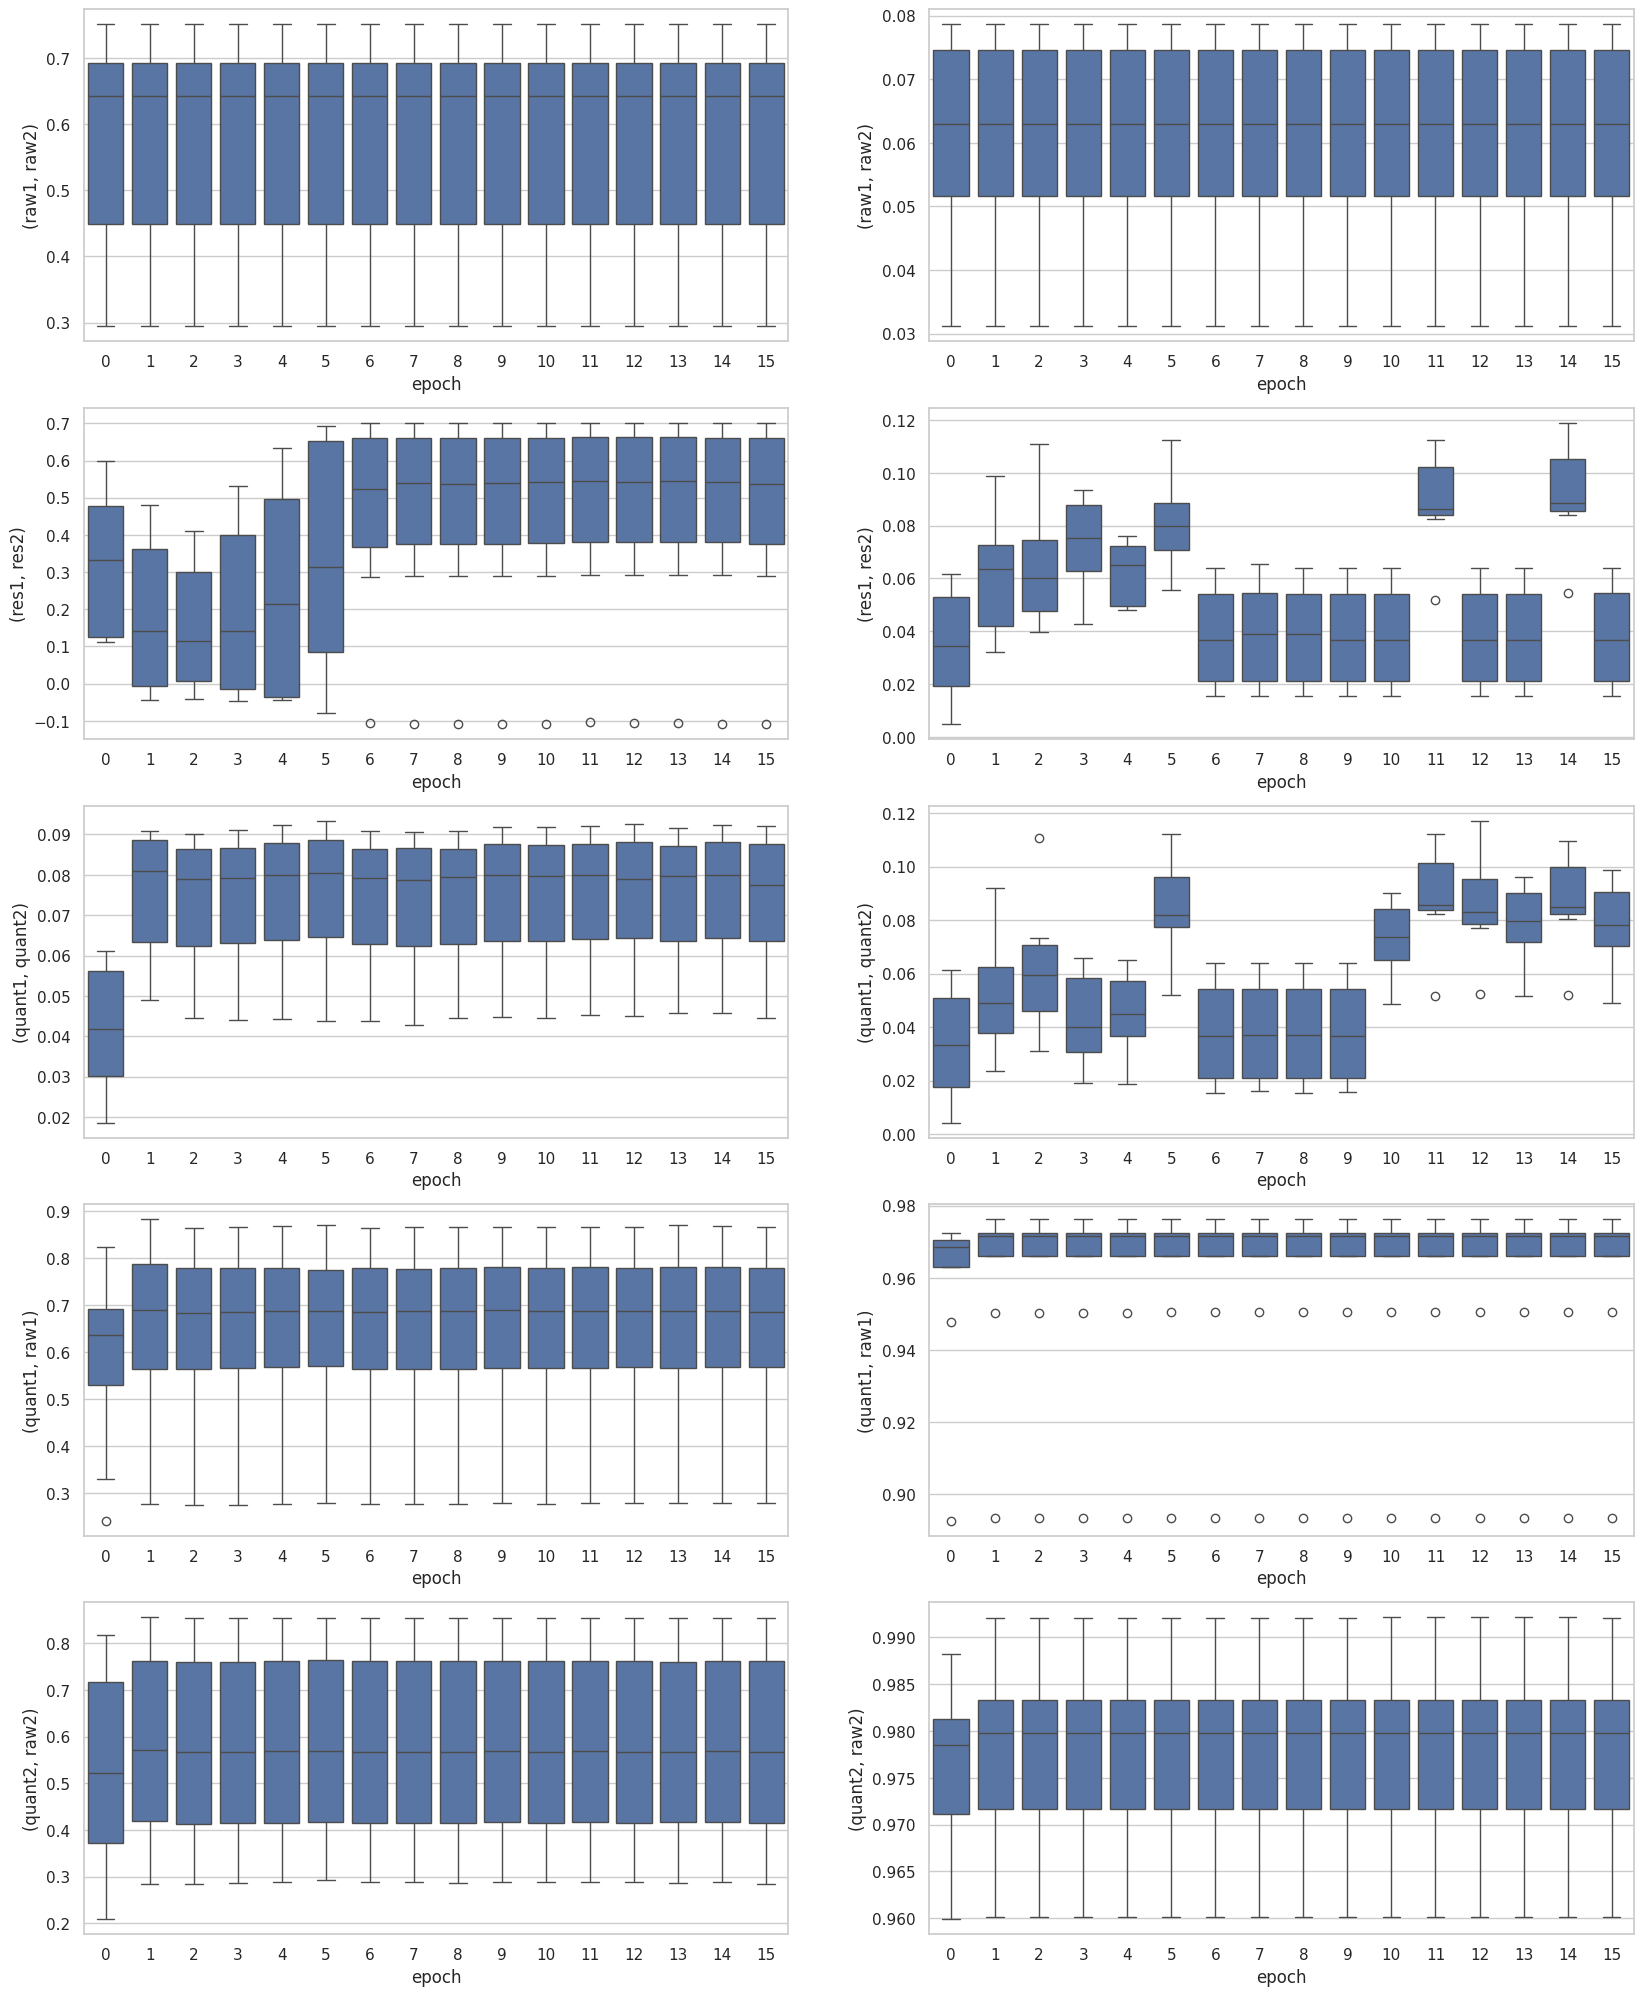

In [44]:
c_dfs = run_analysis(BASE_DIR / "ctcf" / "run_ctcf")
c_dfs[-1]